In [1]:
import numpy as np
import lysis
import os
import re

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import BoundaryNorm, ListedColormap

In [2]:
e = lysis.util.Experiment(os.path.join("..", "..", "data"), experiment_code="2023-01-31-1300")
e.read_file()
file_code = ".f-array.dat"

In [3]:
print(e)

experiment_code : 2023-01-31-1300
data_filenames  : unbinding_time    : tsectPA.dat
                  lysis_time        : lysismat.dat
                  total_lyses       : lenlysisvect.dat
                  degradation_state : deg.p.npy
                  molecule_location : m_loc.p.npy
                  molecule_state    : m_bound.p.npy
                  save_time         : tsave.p.npy
micro_params    : None
macro_params    : binding_rate       : 0.1
                  pore_size          : 0.00010135
                  diffusion_coeff    : 5e-07
                  binding_sites      : 427
                  forced_unbind      : 0.0852
                  average_bind_time  : 27.8
                  grid_node_distance : 1.0862
                  cols               : 93
                  rows               : 121
                  full_row           : 278
                  xz_row             : 185
                  total_edges        : 33,545
                  total_fibers       : 25,761
       

In [4]:
n_save = np.fromfile(os.path.join(e.os_path, "Nsave" + file_code), dtype=np.int32)
n_save += 1
raw_deg = np.fromfile(os.path.join(e.os_path, "deg" + file_code))
raw_tsave = np.fromfile(os.path.join(e.os_path, "tsave" + file_code))
raw_mfpt = np.fromfile(os.path.join(e.os_path, "mfpt" + file_code))

if raw_mfpt.size == e.macro_params.total_trials * e.macro_params.total_molecules:
    mfpt = raw_mfpt.reshape(e.macro_params.total_trials, e.macro_params.total_molecules)
else:
    mfpt = np.expand_dims(raw_mfpt, axis=0)

raw_mapped_deg = -raw_deg
raw_mapped_deg[raw_deg == 0] = np.max(raw_tsave) + e.macro_params.save_interval# float('inf') #
raw_mapped_deg[raw_deg == -1] = 0

mapped_deg = []
tsave = []
start = 0
end = 0
for r in range(e.macro_params.total_trials):
    start = end
    end += n_save[r]
    mapped_deg.append(raw_mapped_deg[start*e.macro_params.total_edges : end*e.macro_params.total_edges].reshape(n_save[r], e.macro_params.total_edges))
    tsave.append(raw_tsave[start:end])

In [5]:
exposed_time = np.empty((e.macro_params.total_trials, e.macro_params.rows-1, e.macro_params.cols), 
                        dtype=np.float_)
for run in range(e.macro_params.total_trials):
    for j in range(e.macro_params.cols):
        for i in range(e.macro_params.rows-1):
            if i == 0:
                exposed_time[run, i, j] = 0;
            else:
                k = lysis.to_fortran_edge_index(i, j, e.macro_params.rows, e.macro_params.cols)
                exposed_time[run, i, j] = max(exposed_time[run, i-1, j], mapped_deg[run][n_save[run]-1, k])
#exposed_time = 10* np.ceil(exposed_time / 10)
exposed_time = exposed_time / 60

In [6]:
y_distance = np.arange(e.macro_params.rows-1)*e.macro_params.grid_node_distance 

In [7]:
deg_fronts = []
for r in range(e.macro_params.total_trials):
    run_deg_fronts = []
    for j in range(e.macro_params.cols):
        col_deg_front = []
        for i in range(1,e.macro_params.rows-1):
            if  exposed_time[r, i-1, j] < exposed_time[r, i, j] < np.max(raw_tsave) + e.macro_params.save_interval:
                col_deg_front.append([exposed_time[r, i, j], y_distance[i]])
        run_deg_fronts.append(np.array(col_deg_front).T)
    deg_fronts.append(run_deg_fronts)

In [8]:
run_mean_velocity = np.empty(e.macro_params.total_trials, dtype=np.float_)
run_std_velocity = np.empty(e.macro_params.total_trials, dtype=np.float_)
for run in range(e.macro_params.total_trials):
    front_velocity = np.empty(e.macro_params.cols, dtype=np.float_)
    for j in range(e.macro_params.cols):
        b, m = np.polynomial.polynomial.polyfit(deg_fronts[run][j][0], deg_fronts[run][j][1], 1)
        front_velocity[j] = m
    run_mean_velocity[run] = np.mean(front_velocity)
    run_std_velocity[run] = np.std(front_velocity)
#print(run_mean_velocity)
print(f"Mean front velocity (over all simulations, over all columns): {np.mean(run_mean_velocity):.3f} microns/min")
print(f"Mean (over all simulations) of standard deviation (over all columns) of front velocity: {np.mean(run_std_velocity):.3f} microns/min")

Mean front velocity (over all simulations, over all columns): 6.270 microns/min
Mean (over all simulations) of standard deviation (over all columns) of front velocity: 0.264 microns/min


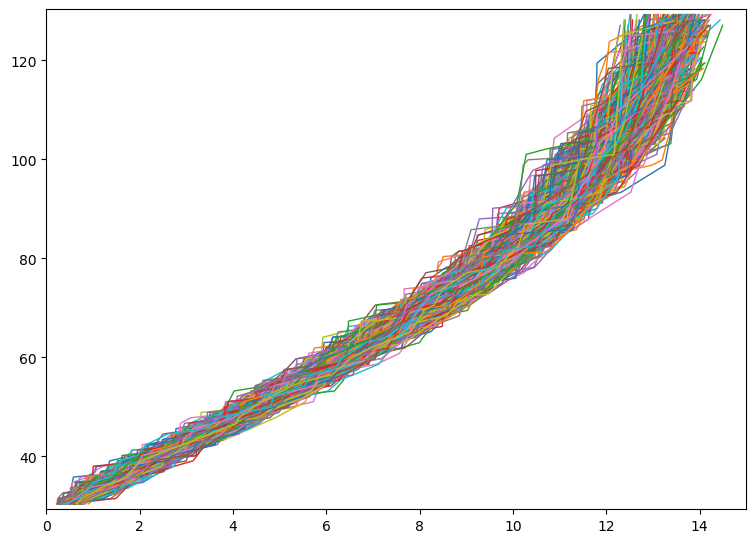

In [9]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlim(0, max([np.max(mapped_deg[r][-1,:]) for r in range(e.macro_params.total_trials)]) // 60 + 1)
ax.set_ylim((e.macro_params.empty_rows-1)*e.macro_params.grid_node_distance,
           (e.macro_params.rows-1)*e.macro_params.grid_node_distance)
for run in range(e.macro_params.total_trials):
    for j in range(e.macro_params.cols):
        plt.plot(deg_fronts[run][j][0], deg_fronts[run][j][1], linewidth=1)

In [10]:
degraded_percent = []
for r in range(e.macro_params.total_trials):
    run_degraded_percent = np.empty(n_save[r], np.float_)
    for t in range(n_save[r]):
        run_degraded_percent[t] = np.count_nonzero(mapped_deg[r][t] <= tsave[r][t]) 
    run_degraded_percent -= e.macro_params.empty_rows*e.macro_params.full_row
    run_degraded_percent = run_degraded_percent / e.macro_params.total_fibers
    degraded_percent.append(run_degraded_percent)

In [11]:
tolerance = 1e-3
slope = []
degradation_rate = np.empty(e.macro_params.total_trials, dtype=np.float_)
offset = np.empty(e.macro_params.total_trials, dtype=np.float_)
for r in range(e.macro_params.total_trials):
    run_slope = np.empty(n_save[r], dtype=np.float_)
    run_slope[0] = degraded_percent[r][0]
    for t in range(1, n_save[r]):
        run_slope[t] = degraded_percent[r][t] - degraded_percent[r][t-1]
    degradation_happening = (tolerance <= run_slope)
    b, m = np.polynomial.polynomial.polyfit(tsave[r][degradation_happening]/60, 
                                            degraded_percent[r][degradation_happening], 
                                            1)
    degradation_rate[r] = m
    offset[r] = b
    slope.append(run_slope)
print(f"Mean degradation rate: {np.mean(degradation_rate)*100:.3f} percent of fibers per min")
print(f"Standard deviation of degradation rate: {np.std(degradation_rate)*100:.3f} percent of fibers per min")

Mean degradation rate: 7.605 percent of fibers per min
Standard deviation of degradation rate: 0.134 percent of fibers per min


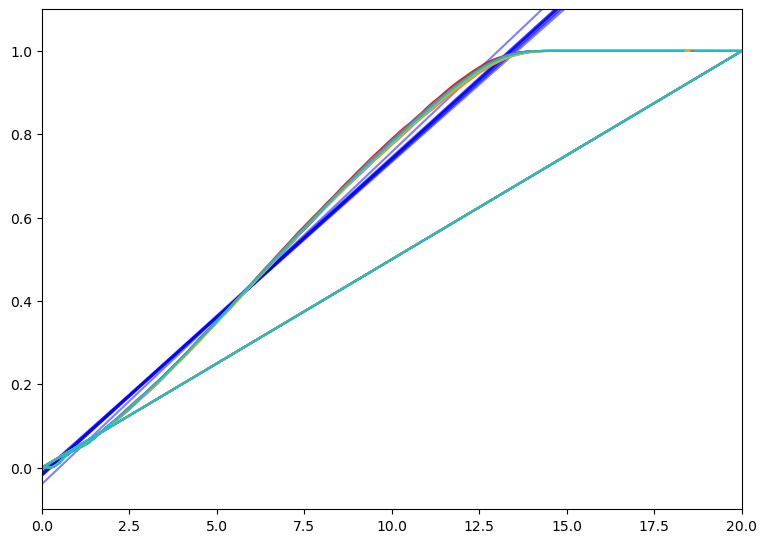

In [12]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlim(0, np.max(raw_tsave) / 60)
ax.set_ylim(-0.1, 1.1)
for r in range(e.macro_params.total_trials):
    plt.plot(tsave[r]/60, degraded_percent[r])
    plt.plot(np.arange(np.max(raw_tsave) // 60 + 1)*degradation_rate[r] + offset[r], color='b', alpha=0.5, zorder=0.1)

In [13]:
print(f"Mean number of molecules that reached the back row: {np.mean(np.count_nonzero(mfpt > 0, axis=1)):,}")
print(f"Mean percent of molecules that reached the back row: {np.mean(np.count_nonzero(mfpt > 0, axis=1))/e.macro_params.total_molecules*100:.1f}%")
print(f"Mean time to reach back row: {np.mean(mfpt[mfpt > 0]/60):.3f} minutes")
print(f"Standard deviation of time to reach back row: {np.std(mfpt[mfpt > 0]/60):.3f} minutes")

Mean number of molecules that reached the back row: 42,511.0
Mean percent of molecules that reached the back row: 98.7%
Mean time to reach back row: 12.420 minutes
Standard deviation of time to reach back row: 3.321 minutes


In [14]:
macro_unbind_pattern = re.compile(r"countmacrounbd=\s*(\d+)")
micro_unbind_pattern = re.compile(r"countmicrounbd=\s*(\d+)")

In [18]:
log_file_name = os.path.join(e.os_path, "macro" + file_code[:-4] + ".txt")
with open(log_file_name, 'r') as file: log_text = file.read()
    
macro_unbinds = re.findall(macro_unbind_pattern, log_text)
micro_unbinds = re.findall(micro_unbind_pattern, log_text)

In [19]:
macro_unbinds, micro_unbinds

(['432441',
  '435297',
  '435324',
  '429610',
  '431904',
  '431280',
  '433480',
  '432748',
  '435071',
  '431183'],
 ['40776',
  '41182',
  '40633',
  '40943',
  '40725',
  '40657',
  '40713',
  '41015',
  '40969',
  '41066'])